In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joypy
import helper_functions
from matplotlib.lines import Line2D

helper = helper_functions.HelperFunctions()

sns.set_palette("viridis")

In [297]:
data_path = 'C:/Users/Arkady/Google Drive/data/beyond_the_reach'
figure_path = 'C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/figures'

figure_format = '.png'

index=['subj_id', 'task', 'trial_no']

choices = pd.read_csv(os.path.join(data_path, 'choices_processed.txt'))
dynamics = pd.read_csv(os.path.join(data_path, 'dynamics_processed.txt'))

choices = choices.set_index(index, drop=False)
dynamics = dynamics.set_index(index, drop=False)

dynamics = dynamics.join(choices.option_chosen)

# choices['Lambda_q'] = choices.groupby(['task', 'option_chosen'])['Lambda'].transform(
#                      lambda x: pd.qcut(x, q=3, labels=['Low', 'Medium', 'High']))

choices['Lambda_q'] = pd.qcut(choices.Lambda, q=3, labels=['Low', 'Medium', 'High'])

dynamics['Lambda_q'] = choices['Lambda_q']

In [298]:
choices.groupby(['task', 'option_chosen', 'Lambda_q']).count()

C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'task' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


subj_id  trial_no  order  is_staircase  \
task    option_chosen Lambda_q                                           
mouse   ll            Low           130       130    130           130   
                      Medium        263       263    263           263   
                      High          589       589    589           589   
        ss            Low           743       743    743           743   
                      Medium        556       556    556           556   
                      High          209       209    209           209   
walking ll            Low           143       143    143           143   
                      Medium        267       267    267           267   
                      High          611       611    611           611   
        ss            Low           722       722    722           722   
                      Medium        522       522    522           522   
                      High          186       186    186           186   

                                ss_delay  ss_amount  ll_delay  ll_amount  \
task    option_chosen Lambda_q                                             
mouse   ll            Low            130        130       130        130   
                      Medium         263        263       263        263   
                      High           589        589       589        589   
        ss            Low            743        743       743        743   
                      Medium         556        556       556        556   
                      High           209        209       209        209   
walking ll            Low            143        143       143        143   
                      Medium         267        267       267        267   
                      High           611        611       611        611   
        ss            Low            722        722       722        722   
                      Medium         522        522       522        522   
                      High           186        186       186        186   

                                is_ss_on_left  trial_time   ...    \
task    option_chosen Lambda_q                              ...     
mouse   ll            Low                 130         130   ...     
                      Medium              263         263   ...     
                      High                589         589   ...     
        ss            Low                 743         743   ...     
                      Medium              556         556   ...     
                      High                209         209   ...     
walking ll            Low                 143         143   ...     
                      Medium              267         267   ...     
                      High                611         611   ...     
        ss            Low                 722         722   ...     
                      Medium              522         522   ...     
                      High                186         186   ...     

                                LL_advantage  Lambda  max_d  idx_max_d  \
task    option_chosen Lambda_q                                           
mouse   ll            Low                130     130    130        130   
                      Medium             263     263    263        263   
                      High               589     589    589        589   
        ss            Low                743     743    743        743   
                      Medium             556     556    556        556   
                      High               209     209    209        209   
walking ll            Low                143     143    143        143   
                      Medium             267     267    267        267   
                      High               611     611    611        611   
        ss            Low                722     722    722        722   
                      Medium             522     522    522        522   
 

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


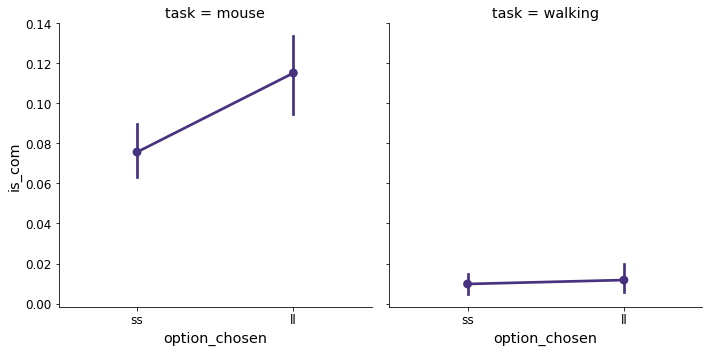

In [299]:
sns.catplot(data=choices, x='option_chosen', y='is_com', col='task', kind='point')

In [300]:
dynamics_walking = dynamics.loc[dynamics.task=='walking', :]
dynamics_mouse = dynamics.loc[dynamics.task=='mouse', :]

choices_walking = choices.loc[choices.task=='walking', :]
choices_mouse = choices.loc[choices.task=='mouse', :]

# Mean trajectories

In [308]:
def get_average_trajectories(dynamics, variables):
    cols = dynamics.index.names + variables    
    dynamics_transposed = dynamics.groupby(by = cols). \
                    apply(lambda x: x.loc[:, ['x', 'y']].reset_index(drop=True).T)
    cols += ['x/y']
    dynamics_transposed.index.names = cols
    
    subj_mean_traj = dynamics_transposed.groupby(level=variables + ['x/y']).apply(np.mean).stack()
    
    subj_mean_traj.index.names = variables + ['x/y', 't']
    subj_mean_traj = subj_mean_traj.unstack('x/y')
    return subj_mean_traj

mean_traj_walking = get_average_trajectories(dynamics_walking, ['option_chosen', 'Lambda_q'])
mean_traj_mouse = get_average_trajectories(dynamics_mouse[~choices_mouse.is_com], ['option_chosen', 'Lambda_q'])

C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'subj_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'task' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'trial_no' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key 

In [319]:
def plot_mean_trajectories(mean_trajectories):
    # TODO: fix colors and legend
    fig, ax = plt.subplots(1, figsize=(10, 10))
    plt.set_cmap('viridis')
    ax.set_aspect(1, adjustable='datalim')
    colors = {'Low': 'C0',
              'High': 'C3'}
    
    for name, group in mean_trajectories.groupby(['option_chosen', 'Lambda_q']):
        ax.plot(mean_trajectories.loc[name].x, mean_trajectories.loc[name].y, 
                lw=3, color=colors[name[1]])
    ax.text(s='Larger \nbut later', x=0.9, y=1, fontsize=20, 
            horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    ax.text(s='Smaller \nbut sooner', x=0.1, y=1, fontsize=20, 
            horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    
    ax.tick_params(axis='both', which='major', labelsize=18)

    custom_lines = [Line2D([0], [0], color='C0', lw=4),
                    Line2D([0], [0], color='C3', lw=4)]

    ax.legend(custom_lines, ['Low $\Lambda$', 'High $\Lambda$'], fontsize=18, loc=5)
#     ax.legend()

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


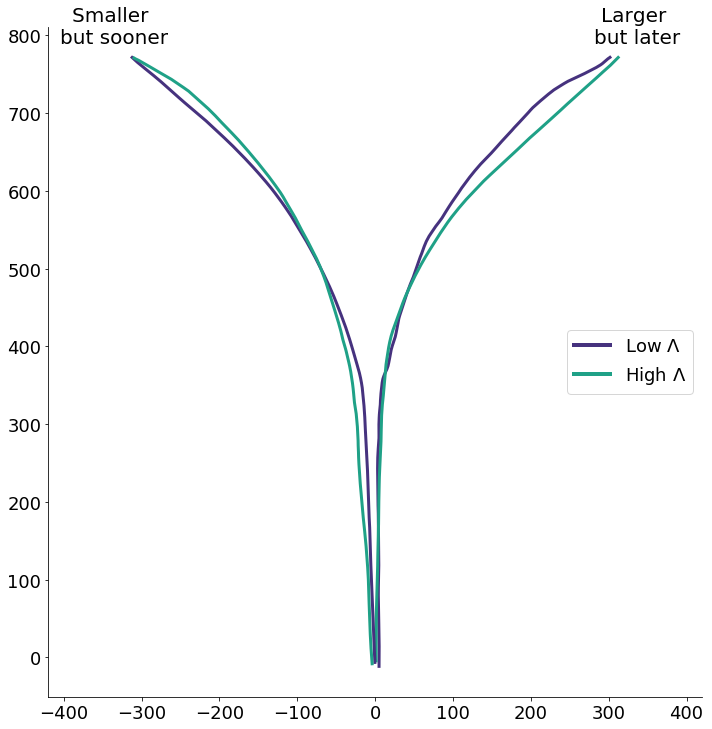

In [320]:
plot_mean_trajectories(mean_traj_mouse[~(mean_traj_mouse.index.get_level_values('Lambda_q')=='Medium')])
plt.savefig(os.path.join(figure_path, 'mean_traj_mouse'+figure_format))

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


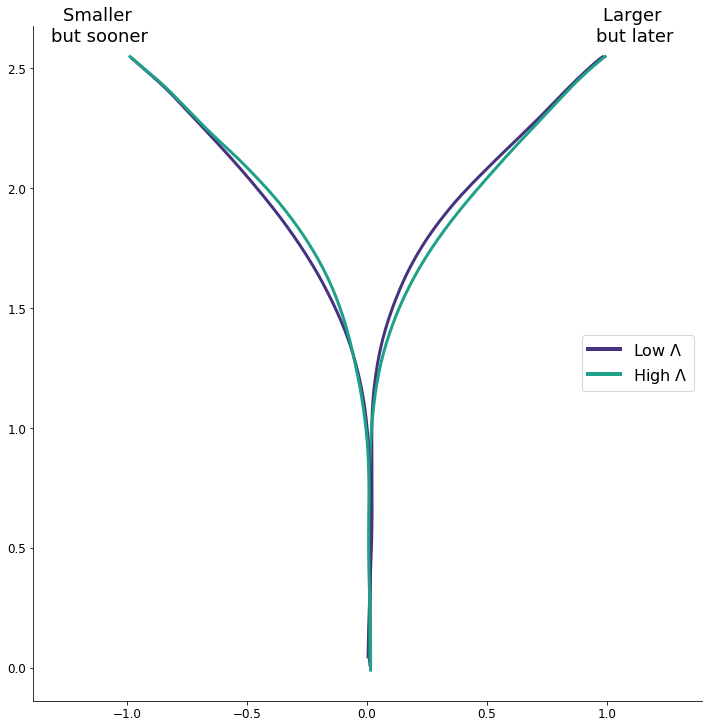

In [318]:
plot_mean_trajectories(mean_traj_walking[~(mean_traj_walking.index.get_level_values('Lambda_q')=='Medium')])
plt.savefig(os.path.join(figure_path, 'mean_traj_walking'+figure_format))

# Posterior plots

In [190]:
max_d_mouse_posterior = pd.read_csv("csv/posterior_mouse_max_d.csv")

TODO: Plot b_Lambda:option_chosenll and b_Lambda:option_chosenss in different colors

In [208]:
df = max_d_mouse_posterior.filter(regex=('b_Lambda:option_chosen.*')).stack().reset_index()

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


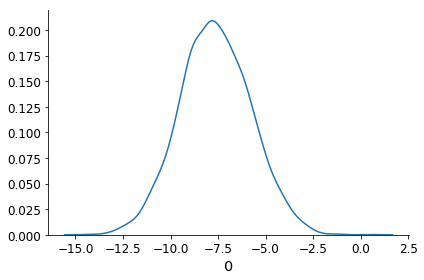

In [218]:
df = max_d_mouse_posterior.filter(regex=('b_Lambda:option_chosen.*')).stack().reset_index()

fig, ax = plt.subplots(1)
sns.distplot(df.loc[df.level_1 == 'b_Lambda:option_chosenll', 0], hist=False)

# joypy.joyplot(df, by='level_1', column=0);